## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
from time import time
import numpy as np
import matplotlib.pyplot as plt
from utils import calc_gso_batch
import seaborn as sns
sns.set_style("darkgrid")
import os
try: 
    JOBID = os.environ["SLURM_JOB_ID"] # get job id from slurm, when training on cluster
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
    HAS_SCREEN = False # for plotting or saving images
except:
    device = torch.device("mps") # apple silicon
    JOBID = "local"
    HAS_SCREEN = True
os.makedirs(f"mg_data/{JOBID}", exist_ok=True)
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

device: mps


# Best MSE loss: 0.087

In [2]:
MODEL_SAVE_PATH = f"mg_data/{JOBID}/mg_planet.pth"
EPOCHS = 300
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
GSO_LOSS_RATIO = 0.1
USE_CURRENTS = True
USE_PROFILES = True
USE_MAGNETIC = True
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187
TRAIN_DS_PATH = "data/train_ds.mat" # generated from prepapre_dataset
EVAL_DS_PATH = "data/eval_ds.mat"

- mean current: -10183.76, std current: 34209.11
- mean magnetic: -0.20, std magnetic: 0.58
- mean f_profile: 33.13, std f_profile: 0.28
- mean p_profile: 9654.42, std p_profile: 8788.29

In [3]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat_path):
        ds_mat = sio.loadmat(ds_mat_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["psi"]).view(-1, 1, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr = to_tensor(ds_mat["rr"]).view(-1,1,64,64) # radial position of pixels (64, 64)
        self.zz = to_tensor(ds_mat["zz"]).view(-1,1,64,64) # vertical position of pixels (64, 64)
        self.currs = ds_mat["currs"] # input currents (n, 14)
        self.magnetic = ds_mat["magnetic"] # input magnetic measurements (n, 187)
        self.f_profile = ds_mat["f_profiles"] # input profiles (n, 101)
        self.p_profile = ds_mat["p_profiles"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        # if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14)
        if USE_CURRENTS: inputs.append((to_tensor(self.currs))) # (n, 14)
        # if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic)+0.2)/0.58) # (n, 187)
        if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic))) # (n, 187)
        # if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.f_profile)-33.13)/0.28, 
        #                                           (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202)
        if USE_PROFILES: inputs.append(torch.cat((to_tensor(self.f_profile), to_tensor(self.p_profile)), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
        #move to device
        self.psi = self.psi.to(device)
        self.inputs = self.inputs.to(device)
        self.rr = self.rr.to(device)
        self.zz = self.zz.to(device)
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx], self.rr[idx], self.zz[idx]

Dataset length: 100
Input shape: torch.Size([403])
Output shape: torch.Size([1, 64, 64])
100


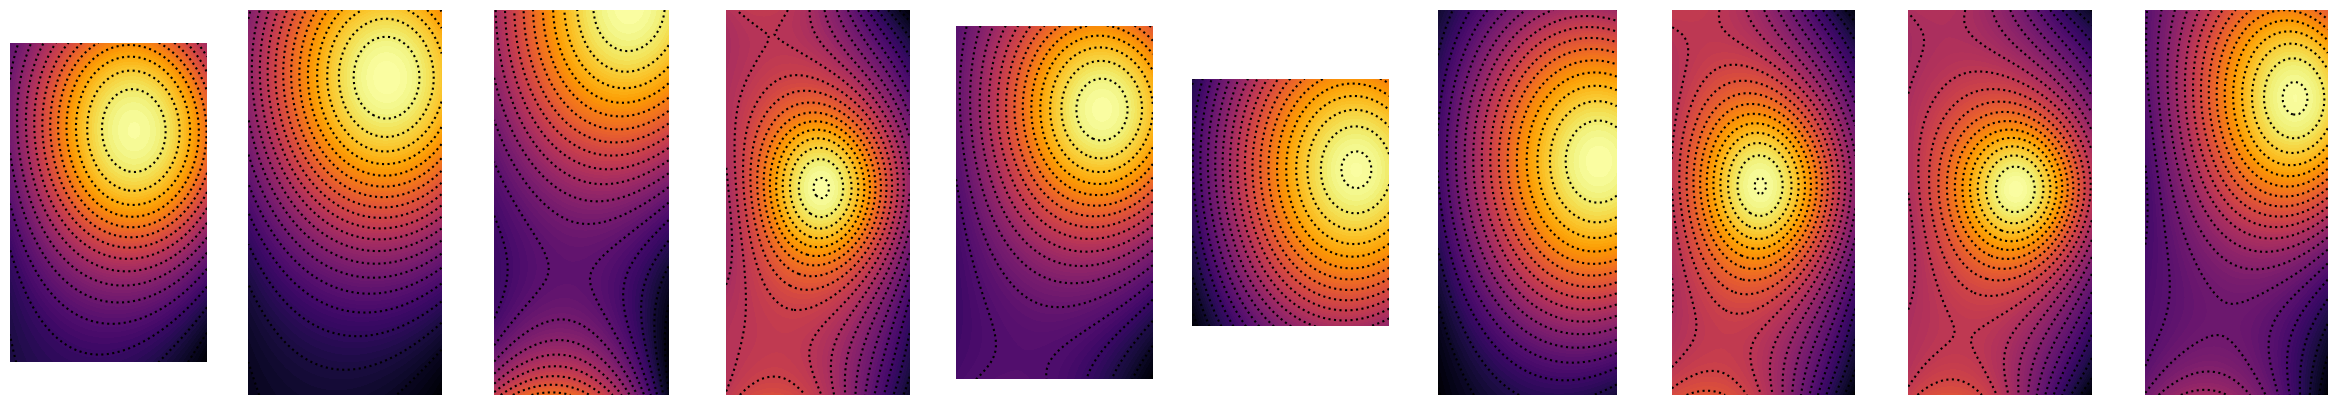

In [4]:
# test dataset
ds = PlaNetDataset(EVAL_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")
n_plot = 10
print(len(ds))
fig, axs = plt.subplots(1, n_plot, figsize=(3*n_plot, 5))

for i, j in enumerate(np.random.randint(0, len(ds), n_plot)):
    psi, rr, zz = ds[j][1].cpu().numpy().squeeze(), ds[j][2].cpu().numpy().squeeze(), ds[j][3].cpu().numpy().squeeze()
    axs[i].contourf(rr, zz, psi, 100, cmap="inferno")
    axs[i].contour(rr, zz, -psi, 20, colors="black", linestyles="dotted")
    axs[i].axis("off")
    axs[i].set_aspect("equal")
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/dataset.png")

In [5]:
# # MODEL: PlaNet: # upsample convolutional neural network > slower > but smoother
# from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, Upsample
# class PlaNet(Module): 
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.interp = 'bilinear' # 'nearest' or 'bilinear'
#         self.n = n = 16
#         self.fc = Sequential(
#             Linear(INPUT_SIZE, 8*n),
#             ReLU(),
#             Linear(8*n, 16*n),
#             ReLU(),
#         )
#         self.unconv = Sequential(
#             Upsample(scale_factor=4, mode=self.interp),
#             Conv2d(16*n, 8*n, kernel_size=3, padding=1),
#             ReLU(),
#             BatchNorm2d(8*n), # batch normalization
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(8*n, 4*n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(4*n, 2*n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(2*n, n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(n, 1, kernel_size=3, padding=1),
#         )
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 16*self.n, 1, 1)
#         x = self.unconv(x)
#         # x = x.view(-1, 64, 64)
#         return x

In [6]:
# MODEL: PlaNet: # Paper net: branch + trunk conenction and everything
from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, Upsample
class PlaNet(Module): # Paper net: branch + trunk conenction and everything
    from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU
    def __init__(self):
        super(PlaNet, self).__init__()
        af = ReLU() # activation function
        #branch
        self.branch = Sequential(
            Linear(INPUT_SIZE, 256), af,
            Linear(256, 128), af,
            Linear(128, 64), af
        )
        #trunk
        # def trunk_block(): # faster
        #     return  Sequential(
        #         Conv2d(1, 8, kernel_size=3, stride=2, padding=1), 
        #         BatchNorm2d(8), 
        #         ReLU(),
        #         Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        #         BatchNorm2d(16), 
        #         ReLU(),
        #         Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        #         BatchNorm2d(32),
        #         ReLU(),
        #     )
        def trunk_block(): 
            return  Sequential(
                Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  BatchNorm2d(8),  af, MaxPool2d(2),
                Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16),  af, MaxPool2d(2),
                Conv2d(16, 32, kernel_size=3, stride=1, padding=1), BatchNorm2d(32), af, MaxPool2d(2),
            )
        self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
        self.trunk_fc = Sequential(
            Linear(2*32*8*8, 128), af,
            Linear(128, 64), af,
            Linear(64, 64), af,
        )
        # head
        self.fc = Sequential(Linear(64, 2048), af)
        self.anti_conv = Sequential(
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(32, 32, kernel_size=3, padding=1), BatchNorm2d(32), af, #NOTE: 32, not 64, paper inconsistency
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(32, 16, kernel_size=3, padding=1), BatchNorm2d(16), af,
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(16, 8, kernel_size=3, padding=1), BatchNorm2d(8), af,
            Conv2d(8, 1, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        xb, r, z = x
        #branch net
        xb = self.branch(xb)
        #trunk net
        r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
        r, z = r.view(-1, 32*8*8), z.view(-1, 32*8*8) # flatten
        xt = torch.cat((r, z), 1) # concatenate
        xt = self.trunk_fc(xt) # fully connected
        # multiply trunk and branch
        x = xt * xb
        #head net
        x = self.fc(x)
        x = x.view(-1, 32, 8, 8)
        x = self.anti_conv(x)
        return x

In [7]:
x = (torch.rand(1, INPUT_SIZE), torch.rand(1, 1, 64, 64), torch.rand(1, 1, 64, 64))
net = PlaNet()
y = net(x)
print(f"in: {[x.shape for x in x]}, out: {y.shape}")

n_sampl = 7
nx = (torch.rand(n_sampl, INPUT_SIZE), torch.rand(n_sampl, 1, 64, 64), torch.rand(n_sampl, 1, 64, 64))
ny = net(nx)
print(f"in: {[x.shape for x in nx]}, out: {ny.shape}")


in: [torch.Size([1, 403]), torch.Size([1, 1, 64, 64]), torch.Size([1, 1, 64, 64])], out: torch.Size([1, 1, 64, 64])
in: [torch.Size([7, 403]), torch.Size([7, 1, 64, 64]), torch.Size([7, 1, 64, 64])], out: torch.Size([7, 1, 64, 64])


## Training

In [8]:
train_ds, val_ds = PlaNetDataset(TRAIN_DS_PATH), PlaNetDataset(EVAL_DS_PATH) # initialize datasets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
best_loss = float('inf') # initialize best loss
start_time = time() # start time
for ep in range(EPOCHS): 
    epoch_time = time()
    model.train()
    trainloss, evalloss = [], []
    for input_currs, psi, rr, zz in train_dl:
        # input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device) # move to device
        optimizer.zero_grad()
        psi_pred = model((input_currs, rr, zz))
        gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
        mse_loss = loss_fn(psi_pred, psi) # mean squared error loss on psi
        gso_loss = loss_fn(gso_pred, gso) # PINN loss on grad shafranov
        loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
        loss.backward()
        optimizer.step()
        trainloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    model.eval()
    with torch.no_grad():
        for input_currs, psi, rr, zz in val_dl:
            # input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device)
            psi_pred = model((input_currs, rr, zz))
            gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
            mse_loss = loss_fn(psi_pred, psi)
            gso_loss = loss_fn(gso_pred, gso)
            loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
            evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    ttot_loss, tmse_loss, tgso_loss = map(lambda x: sum(x)/len(x), zip(*trainloss))
    etot_loss, emse_loss, egso_loss = map(lambda x: sum(x)/len(x), zip(*evalloss))
    if etot_loss < best_loss: # check if improved
        best_loss = etot_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        endp = "*\n"
    else: endp = "\n" 
    print(f"{ep+1}/{EPOCHS}: "
          f"Train:{ttot_loss:.3f}, mse{tmse_loss:.3f}, gso{tgso_loss:.3f} |" +
          f"Eval:{etot_loss:.3f}, mse{emse_loss:.3f}, gso{egso_loss:.3f} |t:{time()-epoch_time:.1f}s,", 
          end=endp,  flush=True)
print(f"Training time: {(time()-start_time)/60:.0f}mins")
print(f"Best val loss: {best_loss:.4f}")

1/40: Train:134.455, mse52.396, gso872.990 |Eval:62.093, mse64.828, gso37.475 |t:1.8s,*
2/40: Train:60.537, mse55.096, gso109.504 |Eval:62.159, mse64.884, gso37.629 |t:0.3s,
3/40: Train:60.166, mse55.524, gso101.948 |Eval:62.364, mse64.956, gso39.030 |t:0.2s,
4/40: Train:55.208, mse53.528, gso70.324 |Eval:62.404, mse65.064, gso38.459 |t:0.2s,
5/40: Train:55.375, mse55.759, gso51.914 |Eval:62.524, mse65.158, gso38.821 |t:0.2s,
6/40: Train:57.013, mse57.782, gso50.091 |Eval:62.590, mse65.255, gso38.599 |t:0.2s,
7/40: Train:56.090, mse57.075, gso47.225 |Eval:62.619, mse65.322, gso38.295 |t:0.2s,
8/40: Train:83.152, mse55.864, gso328.739 |Eval:63.344, mse65.448, gso44.412 |t:0.2s,
9/40: Train:53.017, mse54.445, gso40.159 |Eval:64.012, mse65.444, gso51.124 |t:0.2s,
10/40: Train:57.537, mse57.603, gso56.937 |Eval:64.344, mse65.448, gso54.405 |t:0.2s,
11/40: Train:53.826, mse52.916, gso62.015 |Eval:64.004, mse65.451, gso50.979 |t:0.2s,
12/40: Train:57.939, mse56.247, gso73.169 |Eval:64.355, m

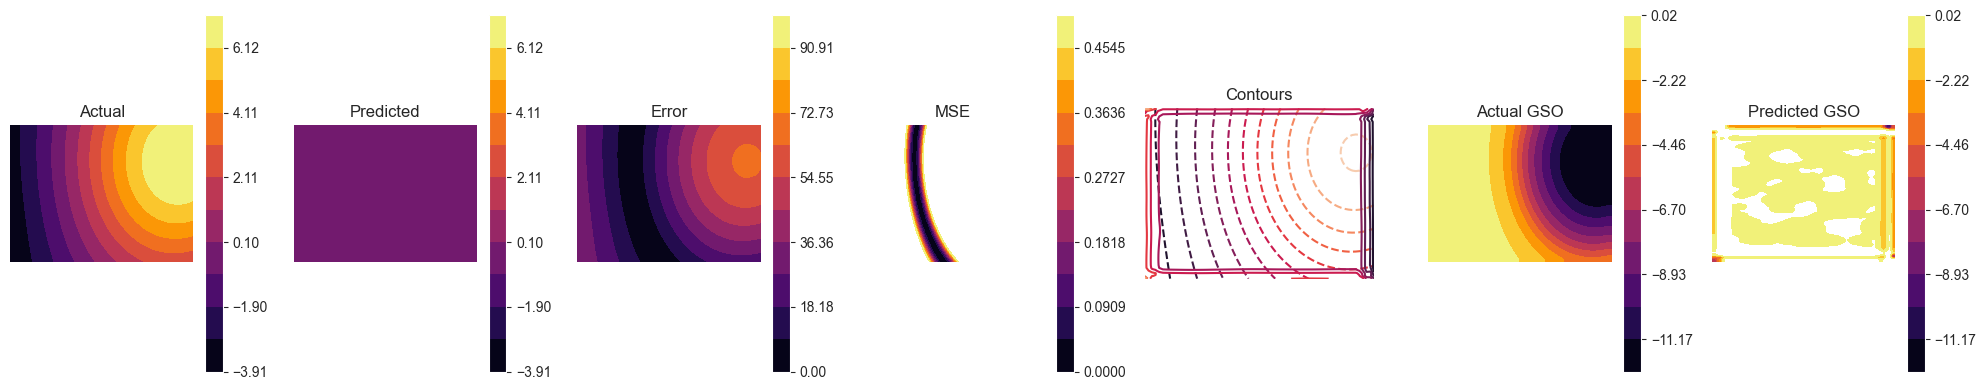

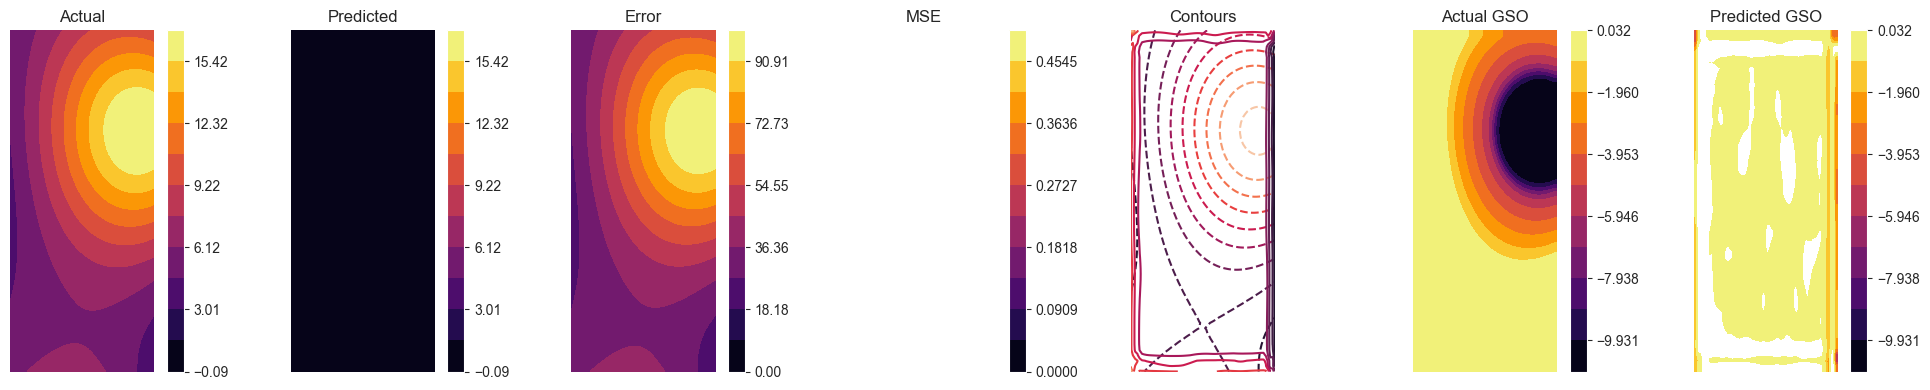

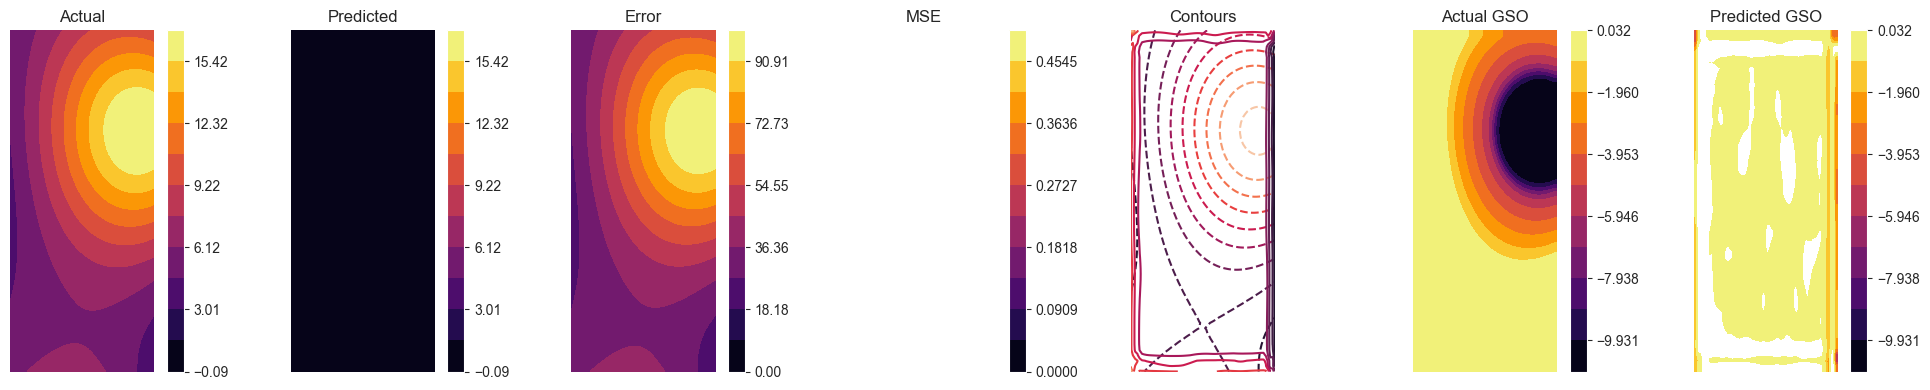

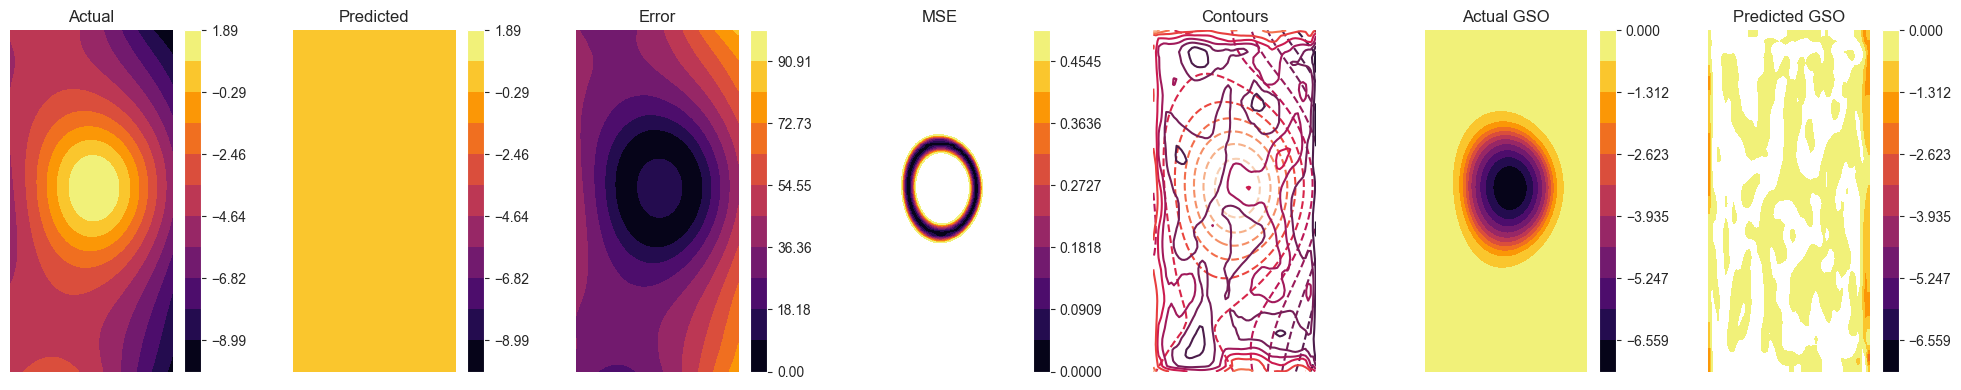

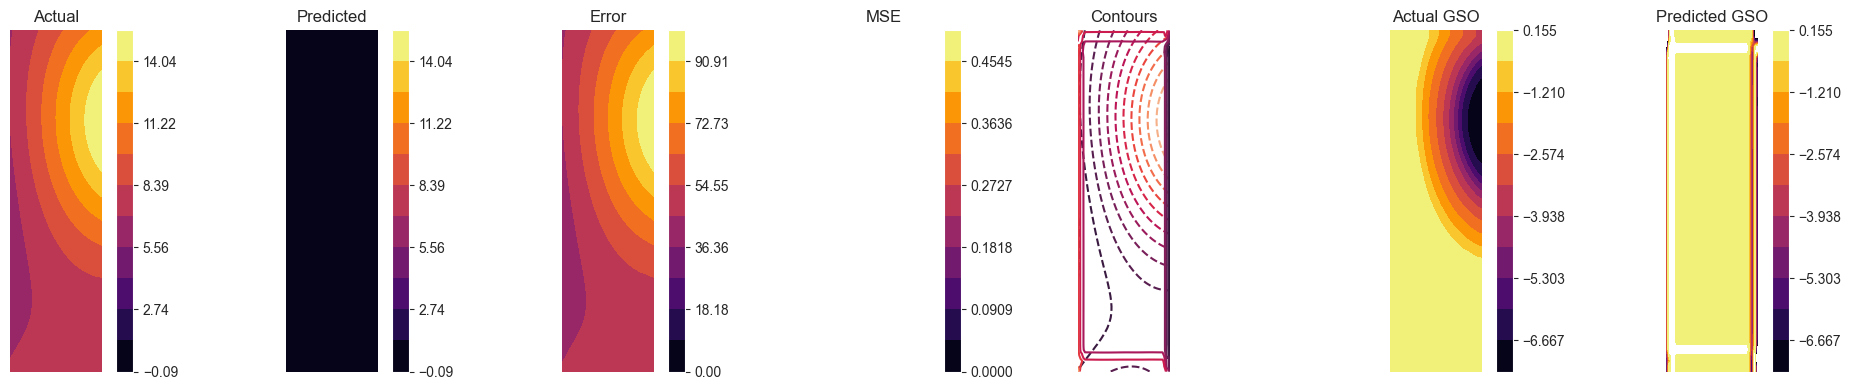

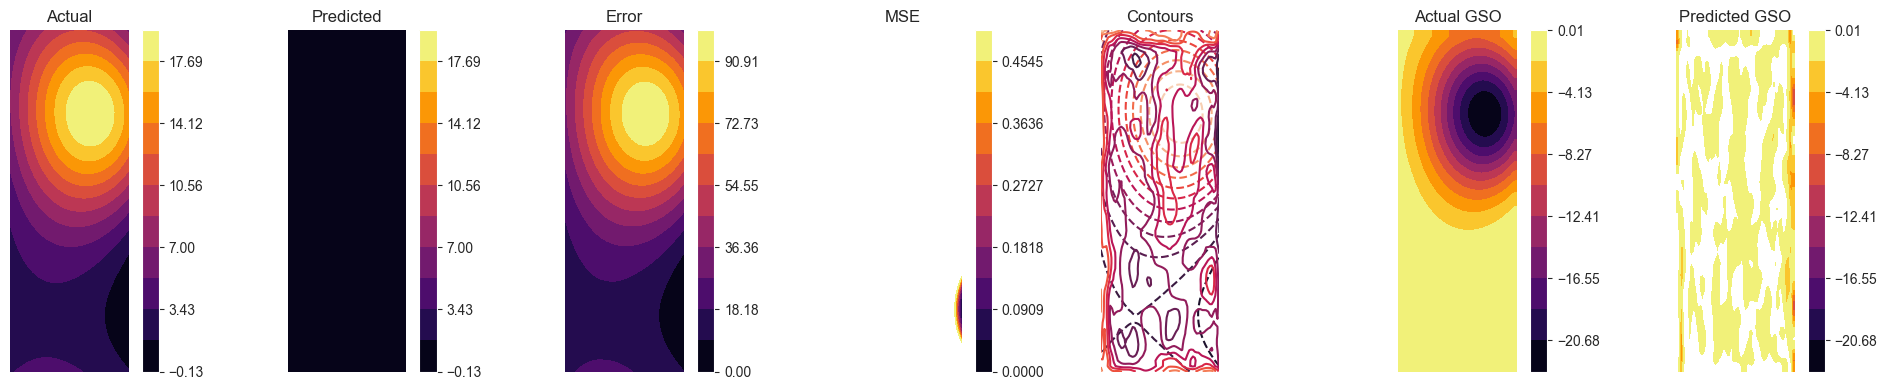

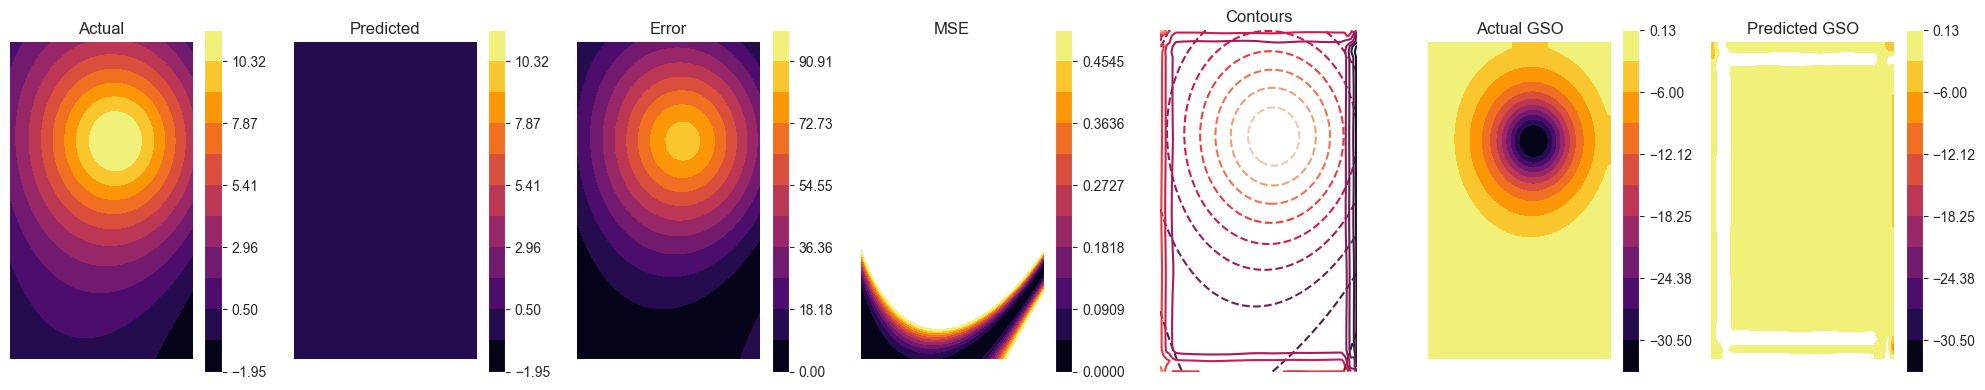

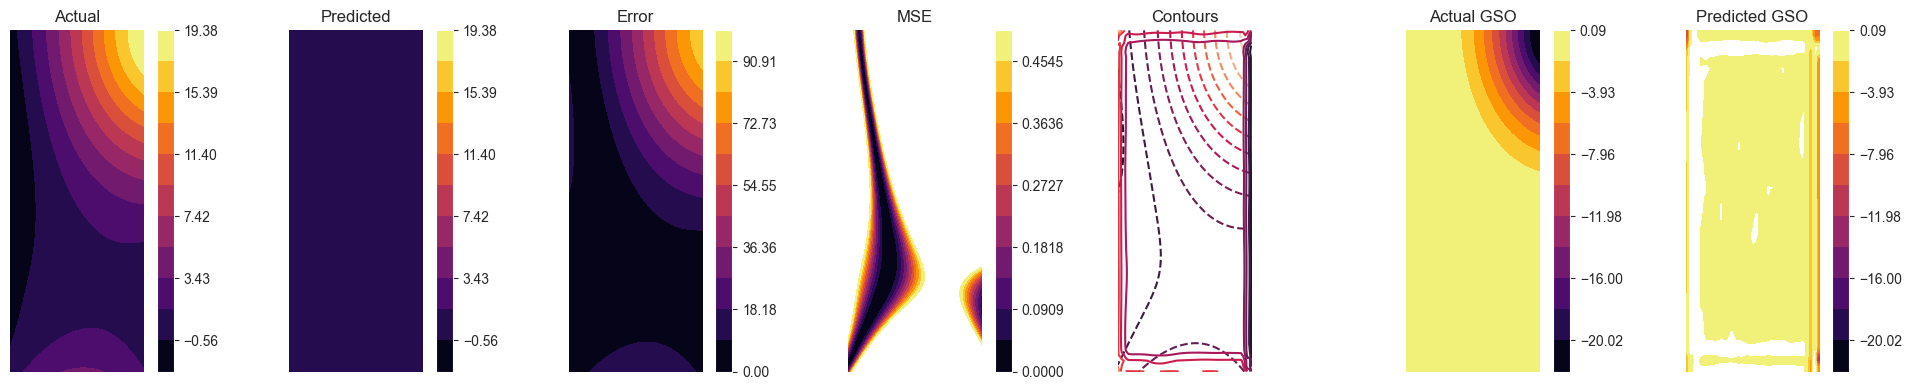

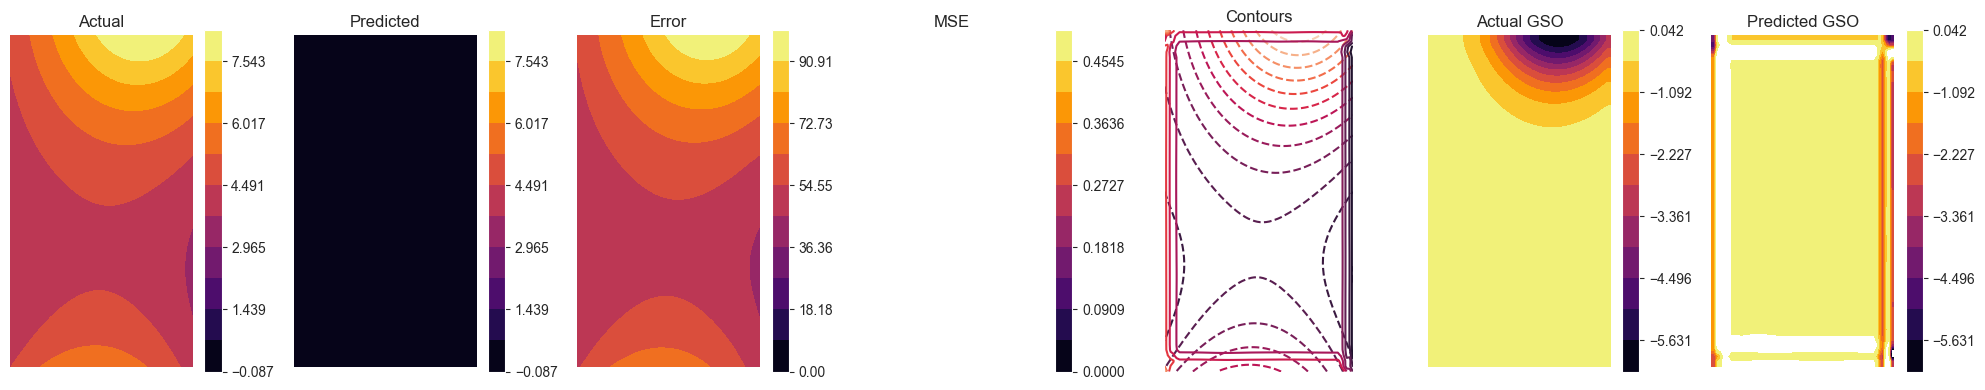

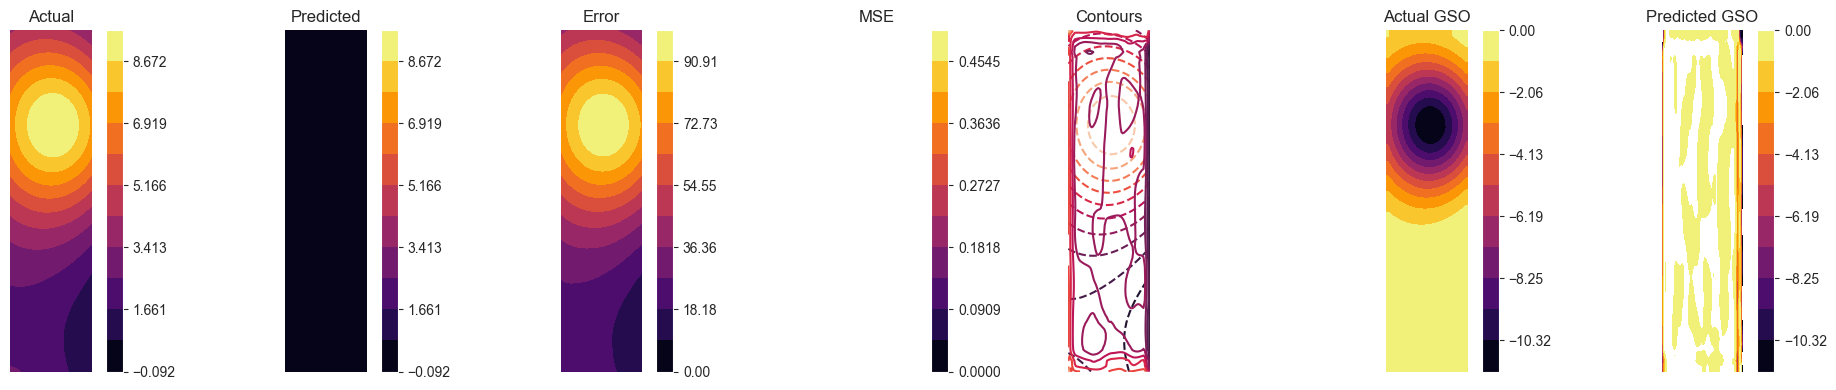

In [14]:
# testing network output
model = PlaNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
ds = PlaNetDataset(EVAL_DS_PATH)
# ds = PlaNetDataset(TRAIN_DS_PATH)
for i in np.random.randint(0, len(ds), 10):  
    fig, axs = plt.subplots(1, 7, figsize=(20, 4))
    input_currs, psi_ds, rr, zz = ds[i]
    input_currs, psi_ds, rr, zz = input_currs.to('cpu'), psi_ds.to('cpu'), rr.to('cpu'), zz.to('cpu')
    input_currs, psi_ds, rr, zz = input_currs.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
    psi_pred = model((input_currs, rr, zz))
    gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
    gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
    gso_range = (gso.max(), gso.min())
    gso_levels = np.linspace(gso_range[1], gso_range[0], 12)
    psi_pred = psi_pred.detach().numpy().reshape(64, 64)
    psi_ds = psi_ds.detach().numpy().reshape(64, 64)
    rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
    ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
    bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred]) # min max psi
    levels = np.linspace(bmin, bmax, 12)
    err = np.abs(psi_ds - psi_pred)*100/abs(bmax - bmin)
    err_levels = np.linspace(0, 100, 12)
    # err = np.abs(psi_ds - psi_pred)*100/abs((psi_ds + psi_pred)/2)
    err_mse = (psi_ds - psi_pred)**2
    mse_levels = np.linspace(0, 0.5, 12)

    im0 = axs[0].contourf(rr, zz, psi_ds, levels, cmap="inferno")
    axs[0].set_title("Actual")
    axs[0].set_aspect('equal')
    fig.colorbar(im0, ax=axs[0]) 

    im1 = axs[1].contourf(rr, zz, psi_pred, levels, cmap="inferno")
    axs[1].set_title("Predicted")
    axs[1].set_aspect('equal')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].contourf(rr, zz, err, err_levels, cmap="inferno")
    axs[2].set_title("Error")
    axs[2].set_aspect('equal')
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].contourf(rr, zz, err_mse, mse_levels, cmap="inferno")
    axs[3].set_title("MSE")
    axs[3].set_aspect('equal')
    fig.colorbar(im3, ax=axs[3])

    c0 = axs[4].contour(rr, zz, psi_ds, levels=12, linestyles='dashed')
    c1 = axs[4].contour(rr, zz, psi_pred, levels=12)
    axs[4].set_title("Contours")
    axs[4].set_aspect('equal')

    im5 = axs[5].contourf(rr, zz, gso, gso_levels, cmap="inferno")
    axs[5].set_title("Actual GSO")
    axs[5].set_aspect('equal')
    fig.colorbar(im5, ax=axs[5])

    im6 = axs[6].contourf(rr, zz, gso_pred, gso_levels, cmap="inferno")
    axs[6].set_title("Predicted GSO")
    axs[6].set_aspect('equal')
    fig.colorbar(im6, ax=axs[6])

    for ax in axs: ax.axis('off')

    plt.tight_layout()
    plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/planet_{i}.png")